In [1]:
%matplotlib inline
from IPython.core.display import Image

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import theano
import theano.tensor as t
from theano.compile.ops import as_op
import daft
from IPython.core.pylabtools import figsize
from scipy import optimize
figsize(12.5, 10)

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
def plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axe_position):
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = axe_position, plot_faults= True, plot_points= False, alpha = 1) # Need to make it transparent!!! 
    

Notice that since the latent occupancy indicators are discrete, we cannot use a gradient-based MCMC step method like HMC or NUTS for this variable. Instead, we will sample using a BinaryMetropolis sampler that proposes only binary values at each iteration for z; for the continuous-valued parameters, theta and p we will use a standard Metropolis sampler.

We sample with both samplers at once by passing them to sample in a list. Each new sample is generated by first applying step1 then step2.

In [4]:
# as we have our model and pygeomod in different paths, let's change the pygeomod path to the default path.
import sys, os
import shutil
sys.path.append("C:\Users\Miguel\workspace\pygeomod\pygeomod")
#sys.path.append(r'/home/jni/git/tmp/pygeomod_tmp')
import geogrid
import geomodeller_xml_obj as gxml
reload(gxml)

<module 'geomodeller_xml_obj' from 'C:\Users\Miguel\workspace\pygeomod\pygeomod\geomodeller_xml_obj.pyc'>

In [5]:
graben = 'PyMC_geomod/Temp_test\horizontal_layers.xml'#C:\Users\Miguel\workspace\Thesis\Thesis\Temp3
print graben

PyMC_geomod/Temp_test\horizontal_layers.xml


In [6]:
#%%timeit
reload(geogrid)
G1 = geogrid.GeoGrid()

# Using G1, we can read the dimensions of our Murci geomodel
G1.get_dimensions_from_geomodeller_xml_project(graben)

nx = 400
ny = 2
nz = 400
G1.define_regular_grid(nx,ny,nz)

C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


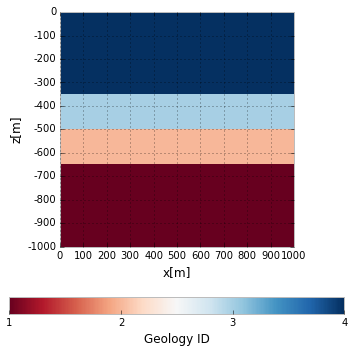

In [7]:
G1.update_from_geomodeller_project(graben)
G1.plot_section('y',cell_pos=1,colorbar = True,  cmap='RdBu', figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True)

In [83]:
@theano.compile.ops.as_op(itypes=[t.dscalar, t.dscalar, t.dscalar],otypes=[t.dscalar])

def f_geomod(alpha,  beta , gamma):
    # Create the array we will use to modify the xml. We have to check the order of the formations
  # Create the array we will use to modify the xml
    samples =  [alpha,beta, gamma,alpha,beta, gamma]
    
    # Load the xml to be modify

    hor_lay = 'PyMC_geomod/Temp_test\horizontal_layers.xml'
    #Create the instance to modify the xml
        # Loading stuff
    #reload(gxml)
    gmod_obj = gxml.GeomodellerClass()
    gmod_obj.load_geomodeller_file(hor_lay);
    # Create a dictionary so we can acces the section through the name
    section_dict = gmod_obj.create_sections_dict()
    
    # ## Get the points of all formation for a given section: Dictionary
    contact_points = gmod_obj.get_formation_point_data(section_dict['Section1'])
    
    #Perform the position Change
    for i, point in enumerate(contact_points):
        gmod_obj.change_formation_point_pos(point, y_coord = [samples[i],samples[i]])
    
    # Check the new position of points
              #points_changed = gmod_obj.get_point_coordinates(contact_points)
              #print "Points coordinates", points_changed
    
    # Write the new xml
    gmod_obj.write_xml("PyMC_geomod/Temp_test/new.xml")   
    
    # Read the new xml
    hor_lay_new = 'PyMC_geomod/Temp_test/new.xml'
    G1 = geogrid.GeoGrid()

    # Getting dimensions and definning grid
    
    G1.get_dimensions_from_geomodeller_xml_project(hor_lay_new)
    
    # Resolution!
    nx = 2
    ny = 2
    nz = 400
    G1.define_regular_grid(nx,ny,nz)

    # Updating project
    G1.update_from_geomodeller_project(hor_lay_new)
 
    # Printing new model
   # G1.plot_section('y',cell_pos=1,colorbar = True,  cmap='RdBu', figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True)
    return np.array([G1])


def f_beta(alpha, thickness_layer1):
    return alpha - thickness_layer1

def f_gamma(beta,thickness_layer2):
    return beta-thickness_layer2

@theano.compile.ops.as_op(itypes=[t.dscalar],otypes=[t.dscalar])
def f_const(gamma):
    print type(gamma)
    if 640>gamma:
        print " im here"
        return 1500
    return 0


In [73]:
from scipy import optimize

In [19]:
print 1./500**2

4e-06


In [16]:
with pm.Model() as model:
    alpha = pm.Normal("alpha", 5000, sd = 2)
    beta = pm.Normal("beta", 5000, tau = 1/2**2)
    step2 = pm.Metropolis()
    M = pm.sample(10000,step2)#, start = start)

ZeroDivisionError: 0.0 cannot be raised to a negative power

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001A66C390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001B5B0B70>]], dtype=object)

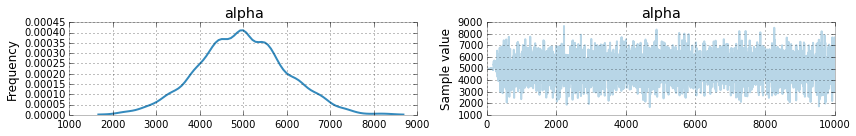

In [12]:
pm.traceplot(M)

In [88]:
with pm.Model() as model:

    alpha = pm.Normal("alpha", -350, 0.05)# value= -250)
  #  beta = pm.Normal("beta", -500, 0.001)# value=-400)
   # gamma = pm.Normal("gamma", -650, 0.001)#, value = 0)
    
    thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.01) # less uncertainty than before
    thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.01)

    
    
    beta = pm.Deterministic("beta",f_beta(alpha,thickness_layer1))
    gamma = pm.Deterministic("gamma", f_gamma(beta,thickness_layer2))
   


    const = pm.Potential("const", f_const(gamma))

    
    geomod = pm.Deterministic("geomod", f_geomod(alpha, beta ,  gamma));
                             
#MODEL!!
   # start = pm.find_MAP(fmin= optimize.fmin_powell)
   # step = pm.NUTS([alpha,beta,gamma,thickness_layer1,thickness_layer2])
    step2 = pm.Metropolis()
    M = pm.sample(10,step2)#, start = start)

<type 'numpy.ndarray'>
 im here
<type 'numpy.ndarray'>
 im here
<type 'numpy.ndarray'>
 im here


ValueError: expected an ndarray
Apply node that caused the error: Elemwise{Composite{(((i0 * (i1 + (i2 * sqr((i3 + i4))))) + i5) - ((i0 * (i1 + (i2 * sqr((i3 + i6))))) + i7))}}[(0, 5)](TensorConstant{0.5}, TensorConstant{-6.4430472524}, TensorConstant{-0.01}, TensorConstant{-100.0}, Subtensor{int64}.0, const, Subtensor{int64}.0, const)
Inputs types: [TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar)]
Inputs shapes: [(), (), (), (), (), 'No shapes', (), 'No shapes']
Inputs strides: [(), (), (), (), (), 'No strides', (), 'No strides']
Inputs values: [array(0.5), array(-6.443047252397437), array(-0.01), array(-100.0), array(99.68893682679732), 1500, array(100.0), 1500]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [80]:
pm.DensityDist?

In [65]:
np.version.version

'1.9.2'

In [47]:
n_samples = 10

alpha_samples, alpha_samples_all = M['alpha'][-n_samples:], M["alpha"][:]
beta_samples, beta_samples_all = M['beta'][-n_samples:], M["beta"][:]
gamma_samples, gamma_samples_all = M['gamma'][-n_samples:], M['gamma'][:]
geomod_samples, geomod_samples_all = M['geomod'][-n_samples:], M['geomod'][:]

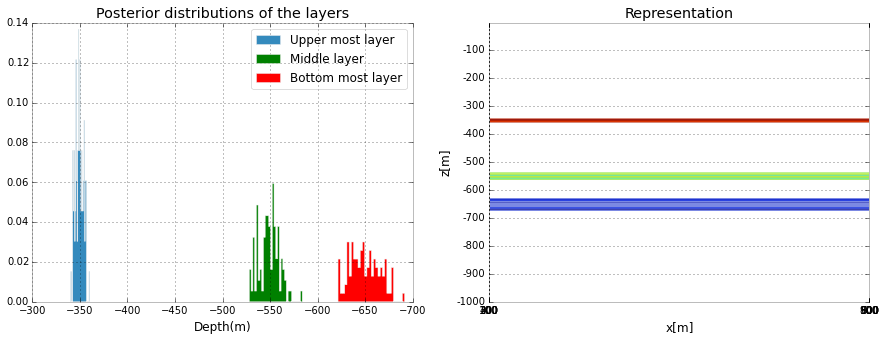

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")


for i in geomod_samples:
    
    i[0].plot_section('y',cell_pos=1,colorbar = True, ax = ax[1], alpha = 0.3, figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = True)

In [56]:
pm.traceplot?

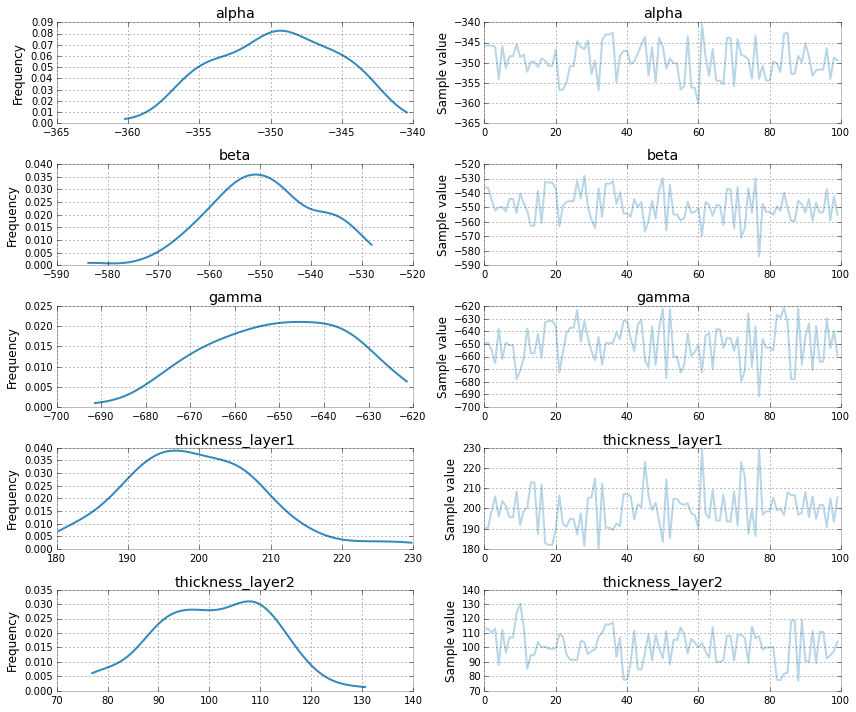

In [51]:
pm.traceplot(M, vars = (alpha,beta,gamma, thickness_layer1, thickness_layer2));

Summary need at least 100 iterations!!!

In [53]:
pm.summary(M, vars = (alpha,beta,gamma, thickness_layer1, thickness_layer2))


alpha:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -349.529         4.170            0.417            [-356.759, -342.899]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -356.725       -352.724       -349.456       -346.093       -342.606


beta:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -549.060         10.544           1.054            [-566.659, -529.622]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -569.510       -555.069       -549.220       -540.393       -529.842


gamma:
 
  Mean             SD               MC Error         95% HPD interval
  -----

In [58]:
pm.Potential??